In [30]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from scipy import stats
import os
import json
import pandas as pd

In [43]:
total_norm = {}
total_gennormalization = {}

In [44]:
def load_data(file_name, branches, process,treedir,selection='',entrystop=None,):

    root_file = uproot.open(file_name)
    df = root_file[treedir+process].pandas.df(branches, entrystop=entrystop).dropna()
    if selection!='' :
        print 'applying ',selection
        df = df.query(selection)
    print("Entries in ntuple:")
    print(len(df))
    return df

In [67]:
year='2018'

process_NLO = 'hh%s_13TeV_125_13TeV_DoubleHTag_0'%year
file_NLO = '/work/nchernya/HHbbgg_ETH_devel/root_files/ntuples_nlo_07042020_preselectionOnly_btagReshape_correct/%s/output_hh_nlo_cHHH1_%s.root'%(year,year)
features = ['genMhh','MX','weight','HHbbggMVA','ttHScore']
#features = ['ttHScore','diHiggs_pt','diHiggs_mass','genMhh','MX','dijet_pt','dijet_eta','diphoton_pt','diphoton_eta','weight',
#            'CMS_hgg_mass','leadingJet_DeepFlavour','subleadingJet_DeepFlavour',
#            'absCosThetaStar_CS','absCosTheta_bb','absCosTheta_gg','customLeadingPhotonIDMVA',
#            'customSubLeadingPhotonIDMVA','leadingPhotonSigOverE','subleadingPhotonSigOverE',
#            'sigmaMOverM','leadingPhoton_pt','leadingPhoton_eta',
#            'subleadingPhoton_pt','subleadingPhoton_eta',
#            'leadingJet_pt','leadingJet_eta','subleadingJet_eta','subleadingJet_pt']
tmp = file_NLO.split('/')
out_dir = tmp[-1].replace('.root','')
df_NLO = load_data(file_NLO, features+['genweight'], process_NLO,'tagsDumper/trees/','(abs(genweight)<0.1)') #& (ttHScore>0.26)
features += ['benchmark_reweight_SM','MVAOutputTransformed']
#features += ['benchmark_reweight_SM']
process_LO = 'hh%s_13TeV_125_13TeV_DoubleHTag_0'%year
file_LO = '/scratch/nchernya/HHbbgg/18_02_2020/output_hh_%s_gen.root'%year
df_LO=load_data(file_LO,features,process_LO,'') #,'(ttHScore>0.26)'
#df_LO=load_data(file_LO,features,process_LO,'tagsDumper/trees/') #,'(ttHScore>0.26)'
out_dir +='_preselectionOnly'

applying  (abs(genweight)<0.1)
Entries in ntuple:
70846
Entries in ntuple:
1500287


genMhh
reducing binning


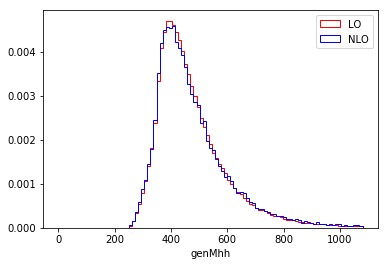

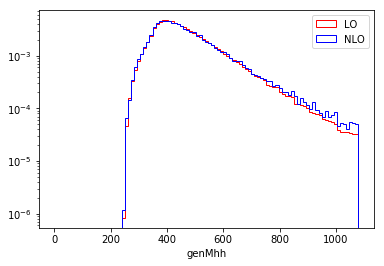

MX
reducing binning


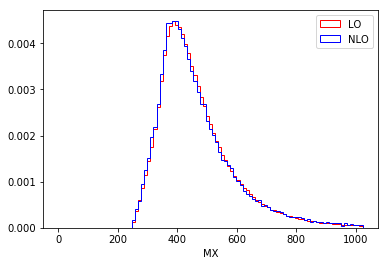

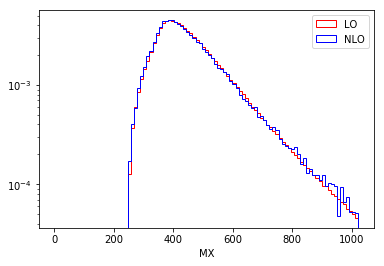

HHbbggMVA
reducing binning


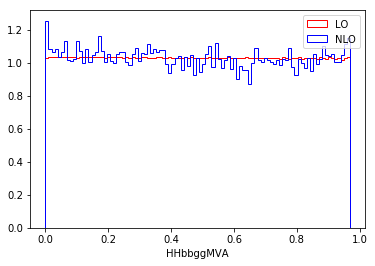

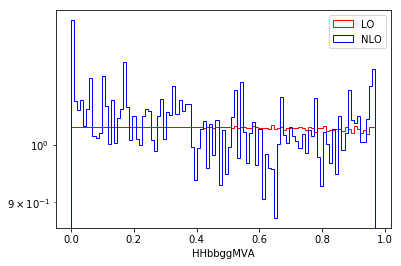

ttHScore


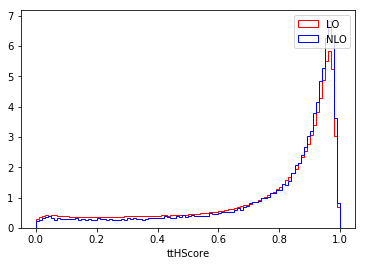

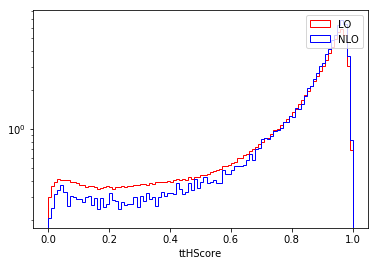

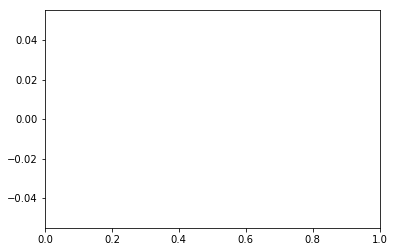

In [65]:
#plotting routine
numbins=100
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
for feat in features:
    if 'weight' in feat: 
        continue
    if 'MVAOutputTransformed' in feat: 
        continue
    print feat 
    #set the same range
    if ('pt' in feat or 'mass' in feat or 'M' in feat or 'SigOverE' in feat) and (feat not in 'CMS_hgg_mass'):
        print "reducing binning"
        nbins = np.linspace(0.0, np.quantile(df_LO[feat],0.95) , numbins)
    else:
        nbins = numbins
    #val_of_bins_x1, edges_of_bins_x1, patches_x1  = plt.hist(df_LO[feat],label='LO',histtype='step',bins=nbins,color='red',density='True',weights=df_LO['weight']*df_LO['benchmark_reweight_SM'])
    if 'HHbbggMVA' in feat : val_of_bins_x1, edges_of_bins_x1, patches_x1  = plt.hist(df_LO['MVAOutputTransformed'],label='LO',histtype='step',bins=nbins,color='red',density='True',weights=df_LO['weight']*df_LO['benchmark_reweight_SM'])
    else :  val_of_bins_x1, edges_of_bins_x1, patches_x1  = plt.hist(df_LO[feat],label='LO',histtype='step',bins=nbins,color='red',density='True',weights=df_LO['weight']*df_LO['benchmark_reweight_SM'])
    val_of_bins_x2, edges_of_bins_x2, patches_x2 = plt.hist(df_NLO[feat],label='NLO',histtype='step',bins=nbins,color='blue',density='True',weights=df_NLO['weight'])
    plt.legend(loc="upper right")

    plt.xlabel(feat.replace('_',' ').replace('pt','Pt'))
    plt.savefig(os.path.join(out_dir, str(feat)+".png"))
    plt.show()
    
    plt.yscale('log')
    if 'HHbbggMVA' in feat : val_of_bins_x1, edges_of_bins_x1, patches_x1  = plt.hist(df_LO['MVAOutputTransformed'],label='LO',histtype='step',bins=nbins,color='red',density='True',weights=df_LO['weight']*df_LO['benchmark_reweight_SM'])
    else : val_of_bins_x1, edges_of_bins_x1, patches_x1  = plt.hist(df_LO[feat],label='LO',histtype='step',bins=nbins,color='red',density='True',weights=df_LO['weight']*df_LO['benchmark_reweight_SM'])    
    #val_of_bins_x1, edges_of_bins_x1, patches_x1  = plt.hist(df_LO[feat],label='LO',histtype='step',bins=nbins,color='red',density='True',weights=df_LO['weight']*df_LO['benchmark_reweight_SM'])
    val_of_bins_x2, edges_of_bins_x2, patches_x2 = plt.hist(df_NLO[feat],label='NLO',histtype='step',bins=nbins,color='blue',density='True',weights=df_NLO['weight'])
    plt.xlabel(feat.replace('_',' ').replace('pt','Pt'))
    plt.legend(loc="upper right")
    plt.savefig(os.path.join(out_dir, str(feat)+"_log.png"))

    plt.show()
    plt.yscale('linear')


In [60]:
print("fraction of negative weights:"+str(np.count_nonzero(df_NLO["weight"]<0)/float(len(df_NLO))*100)+"%")

fraction of negative weights:5.61819676929%


In [61]:
renorm_file = open('/work/nchernya/DiHiggs/inputs/20_12_2019/reweighting_normalization_18_12_2019.json').read()
normalizations_json = json.loads(renorm_file)

In [68]:
#powheg_nlo_xsec = 0.02675

total_norm[year] = {}
total_norm[year]['LO'] = sum(df_LO["weight"]*df_LO["benchmark_reweight_SM"]/normalizations_json[year]['benchmark_SM_normalization'])
total_norm[year]['NLO'] = sum(df_NLO["weight"])#/powheg_nlo_xsec

In [69]:
print total_norm
#print year, 'ratio NLO/LO = %.3f'%(total_norm[year]['NLO']/total_norm[year]['LO'])
for y in ['2016','2017','2018']:
    print y, 'ratio NLO/LO = %.3f'%(total_norm[y]['NLO']/total_norm[y]['LO'])


{'2017': {'LO': 0.36817130717486185, 'NLO': 0.3643588210689487}, '2016': {'LO': 0.38476565635043974, 'NLO': 0.3599813378907837}, '2018': {'LO': 0.3769882454481142, 'NLO': 0.3479559236230223}}
2016 ratio NLO/LO = 0.936
2017 ratio NLO/LO = 0.990
2018 ratio NLO/LO = 0.923


In [71]:
###Check the total normalization :
total_gennormalization = {}
#Cross sections from genAnalyzer :
xsec_dict = {}
xsec_dict['ggHH_kl_1_kt_1'] = 0.02675
xsec_dict['ggHH_kl_0_kt_1'] = 0.06007
xsec_dict['ggHH_kl_5_kt_1'] = 0.07903
xsec_dict['ggHH_kl_2p45_kt_1'] = 0.01133

years = '2016,2017,2018'.split(',')
#years = '2018'.split(',')

for cHHH in '0,1,2p45,5'.split(','):
#for cHHH in '0'.split(','):

    total_gennormalization['ggHH_kl_%s_kt_1'%cHHH] = {}
    total_gennormalization['ggHH_kl_%s_kt_1'%cHHH]['gen_xsec_powheg'] = xsec_dict['ggHH_kl_%s_kt_1'%cHHH]
    total_gennormalization['ggHH_kl_%s_kt_1'%cHHH]['kl'] = float( ('%s'%cHHH).replace('p','.') )
    total_gennormalization['ggHH_kl_%s_kt_1'%cHHH]['LHE_SF_powheg'] = {}
    for year in years:
        process_NLO = 'hh%s_13TeV_125_13TeV_DoubleHTag_0'%year
        process_NLO_noTag = 'hh%s_13TeV_125_13TeV_NoTag_0'%year
        file_dir = '/work/nchernya/DiHiggs/inputs/18_02_2020/nlo/'
        file_NLO = file_dir+'output_hh_nlo_cHHH%s_%s.root'%(cHHH,year)
        weights = ['weight','genweight']
        df_NLO_selected = load_data(file_NLO,weights, process_NLO,'genDiphotonDumper/trees/')
        df_NLO_no_tag = load_data(file_NLO, weights, process_NLO_noTag,'genDiphotonDumper/trees/')
        
        df_NLO_total = pd.concat([df_NLO_selected, df_NLO_no_tag])
        total_gennormalization['ggHH_kl_%s_kt_1'%cHHH]['LHE_SF_powheg'][year] = round(sum(df_NLO_total['weight'])/sum(df_NLO_total.query('abs(genweight)<0.1')['weight']),3)
        print total_gennormalization['ggHH_kl_%s_kt_1'%cHHH]['LHE_SF_powheg'][year]
        
        
#_,_,_ = plt.hist(df_NLO_total.query('abs(genweight)>1.')['genweight'],histtype='step',color='red')
#max(df_NLO_total['genweight'])
#print sum((df_NLO_total['weight']))
#print sum(df_NLO_total.query('abs(genweight)<0.1')['weight'])


Entries in ntuple:
60697
Entries in ntuple:
131103
1.001
Entries in ntuple:
28926
Entries in ntuple:
65474
1.0
Entries in ntuple:
63175
Entries in ntuple:
136825
1.208
Entries in ntuple:
66521
Entries in ntuple:
133479
1.003
Entries in ntuple:
64907
Entries in ntuple:
135093
0.999
Entries in ntuple:
65754
Entries in ntuple:
131646
1.027
Entries in ntuple:
66357
Entries in ntuple:
133643
1.005
Entries in ntuple:
64457
Entries in ntuple:
135543
1.0
Entries in ntuple:
66504
Entries in ntuple:
133496
1.002
Entries in ntuple:
48616
Entries in ntuple:
126384
1.009
Entries in ntuple:
53820
Entries in ntuple:
145180
1.0
Entries in ntuple:
55524
Entries in ntuple:
144476
1.0


In [72]:
print total_gennormalization

{'ggHH_kl_1_kt_1': {'LHE_SF_powheg': {'2017': 0.999, '2016': 1.003, '2018': 1.027}, 'gen_xsec_powheg': 0.02675, 'kl': 1.0}, 'ggHH_kl_0_kt_1': {'LHE_SF_powheg': {'2017': 1.0, '2016': 1.001, '2018': 1.208}, 'gen_xsec_powheg': 0.06007, 'kl': 0.0}, 'ggHH_kl_5_kt_1': {'LHE_SF_powheg': {'2017': 1.0, '2016': 1.009, '2018': 1.0}, 'gen_xsec_powheg': 0.07903, 'kl': 5.0}, 'ggHH_kl_2p45_kt_1': {'LHE_SF_powheg': {'2017': 1.0, '2016': 1.005, '2018': 1.002}, 'gen_xsec_powheg': 0.01133, 'kl': 2.45}}


In [74]:
date = '16_04_2020'
with open(file_dir+'HH_NLO_gen_xsec_%s.json'%date, 'w') as fp:
    json.dump(total_gennormalization, fp)

In [75]:
SM_normalizations_NLO = {}
SM_normalizations_LO = {}

In [76]:
def eval_nnlo_xsec_ggF(kl):
    SF = 1.115  #1.115 is sigma_NNLO+FTapprox / sigma_NLO for SM = 31.05/27.84
    #fit to the parabola
    A = 62.5339
    eA = 2.9369
    B = -44.3231
    eB = 1.9286
    C = 9.6340
    eC = 0.5185
    return SF*(A+B*kl+C*kl*kl)

In [103]:
year='2016'

lumi = {}
lumi['2016']=35.9
lumi['2017']=41.5
lumi['2018']=59.5

BR_hhbbgg = 0.58*0.00227*2

sample_name = 'ggHH_kl_1_kt_1'

LHEweight_rescale = '/work/nchernya/DiHiggs/inputs/18_02_2020/nlo/HH_NLO_gen_xsec_16_04_2020.json'
LHEweight_rescale_dict = json.loads(open(LHEweight_rescale).read())
norm_LO = '/work/nchernya/DiHiggs/inputs/20_12_2019/reweighting_normalization_18_12_2019.json'
normalization_LO = json.loads(open(norm_LO).read())

process_NLO = 'hh%s_13TeV_125_13TeV_DoubleHTag_0'%year
file_NLO = '/work/nchernya/HHbbgg_ETH_devel/root_files/ntuples_nlo_07042020_preselectionOnly_btagReshape_correct/%s/output_hh_nlo_cHHH1_%s.root'%(year,year)
features = ['MX','weight','HHbbggMVA','ttHScore','leadingJet_pt','Mjj']
tmp = file_NLO.split('/')
out_dir = tmp[-1].replace('.root','')
df_NLO = load_data(file_NLO, features+['genweight'], process_NLO,'tagsDumper/trees/','abs(genweight)<0.1')
features += ['benchmark_reweight_SM','MVAOutputTransformed']
#features += ['benchmark_reweight_SM']
process_LO = 'hh%s_13TeV_125_13TeV_DoubleHTag_0'%year
file_LO = '/scratch/nchernya/HHbbgg/18_02_2020/output_hh_%s_gen.root'%year
df_LO=load_data(file_LO,features,process_LO,'')
#df_LO=load_data(file_LO,features,process_LO,'tagsDumper/trees/')
out_dir = 'preselection'

applying  abs(genweight)<0.1
Entries in ntuple:
71749
Entries in ntuple:
260878


In [104]:
df_NLO['leadingJet_pt_Mjj'] = df_NLO['leadingJet_pt']/df_NLO['Mjj'] 
df_LO['leadingJet_pt_Mjj'] = df_LO['leadingJet_pt']/df_LO['Mjj'] 

In [105]:
#nlo_renormalization =  (eval_nnlo_xsec_ggF(LHEweight_rescale_dict[sample_name]['kl'])/LHEweight_rescale_dict[sample_name]['gen_xsec_powheg']*BR_hhbbgg)*LHEweight_rescale_dict[sample_name]['LHE_SF_powheg'][year] #ggHH normalization for NLO samples

nlo_renormalization =  (eval_nnlo_xsec_ggF(LHEweight_rescale_dict[sample_name]['kl'])*BR_hhbbgg)*LHEweight_rescale_dict[sample_name]['LHE_SF_powheg'][year] #ggHH normalization for NLO samples



In [106]:
selection = '(ttHScore>0.26)&(leadingJet_pt_Mjj>0.55)'
#selection = '(ttHScore>-1.)' #test
selection_NLO = selection + ' & (HHbbggMVA>0.37) & (abs(genweight)<0.1)'
selection_LO = selection + ' & (MVAOutputTransformed>0.37)'
#print sum(df_NLO.query(selection_NLO)['weight'])*nlo_renormalization*lumi[year]

In [107]:
SM_normalizations_NLO[year] = {}
SM_normalizations_NLO[year]['MVAselection_ptMjj'] = sum(df_NLO.query(selection_NLO)['weight'])*nlo_renormalization*lumi[year]
SM_normalizations_NLO[year]['preselection'] = sum(df_NLO.query('(abs(genweight)<0.1)&(ttHScore>0.26)')['weight'])*nlo_renormalization*lumi[year]

xsec_LO = 31.05
SM_normalizations_LO[year] = {}
SM_normalizations_LO[year]['MVAselection_ptMjj'] = sum(df_LO.query(selection_LO)['weight']*df_LO.query(selection_LO)['benchmark_reweight_SM'])*lumi[year]/normalization_LO[year]['benchmark_SM_normalization']*xsec_LO*BR_hhbbgg
SM_normalizations_LO[year]['preselection'] = sum(df_LO.query('(ttHScore>0.26)')['weight']*df_LO.query('(ttHScore>0.26)')['benchmark_reweight_SM'])*lumi[year]/normalization_LO[year]['benchmark_SM_normalization']*xsec_LO*BR_hhbbgg


In [108]:

for year in '2016,2017,2018'.split(','):
    print year
    print 'ratio NLO/LO'
    print 'MVA  > 0.37 : ',SM_normalizations_NLO[year]['MVAselection_ptMjj']/SM_normalizations_LO[year]['MVAselection_ptMjj']
    print 'preselection : ',SM_normalizations_NLO[year]['preselection']/SM_normalizations_LO[year]['preselection']
    print ''
    

2016
ratio NLO/LO
MVA  > 0.37 :  0.947423151773
preselection :  0.969133202468

2017
ratio NLO/LO
MVA  > 0.37 :  1.0053788344
preselection :  1.01259349129

2018
ratio NLO/LO
MVA  > 0.37 :  0.959671473984
preselection :  0.968950674857



## Calculating b-tag reshape SF

In [24]:
btagSF = {}

years = '2016,2017,2018'.split(',')

for cHHH in '0,1,2p45,5'.split(','):
    #btagSF['ggHH_kl_%s_kt_1'%cHHH] = {}
    for year in years:
        process_NLO = 'hh%s_13TeV_125_13TeV_DoubleHTag_0'%year
        file_dir = '/work/nchernya/HHbbgg_ETH_devel/root_files/ntuples_nlo_07042020_preselectionOnly_btagReshape/%s/'%year
        file_NLO = file_dir+'output_hh_nlo_cHHH%s_%s.root'%(cHHH,year)
        weights = ['weight','genweight','btagReshapeWeight']
        df_NLO_selected = load_data(file_NLO,weights, process_NLO,'tagsDumper/trees/','abs(genweight)<0.1')
        totWeight = sum(df_NLO_selected['weight'])
        originalWeight = sum(df_NLO_selected['weight']/df_NLO_selected['btagReshapeWeight'])
        #btagSF['ggHH_kl_%s_kt_1'%cHHH][year] = round(originalWeight/totWeight,3)
        btagSF['hh_nlo_cHHH%s%s'%(cHHH,year)] = round(originalWeight/totWeight,3)

applying  abs(genweight)<0.1
Entries in ntuple:
65870
applying  abs(genweight)<0.1
Entries in ntuple:
31788
applying  abs(genweight)<0.1
Entries in ntuple:
68619
applying  abs(genweight)<0.1
Entries in ntuple:
71749
applying  abs(genweight)<0.1
Entries in ntuple:
70330
applying  abs(genweight)<0.1
Entries in ntuple:
70846
applying  abs(genweight)<0.1
Entries in ntuple:
72683
applying  abs(genweight)<0.1
Entries in ntuple:
71150
applying  abs(genweight)<0.1
Entries in ntuple:
72844
applying  abs(genweight)<0.1
Entries in ntuple:
55172
applying  abs(genweight)<0.1
Entries in ntuple:
54133
applying  abs(genweight)<0.1
Entries in ntuple:
63013


In [25]:
print btagSF

{'hh_nlo_cHHH02017': 1.016, 'hh_nlo_cHHH02016': 1.012, 'hh_nlo_cHHH02018': 1.007, 'hh_nlo_cHHH52016': 1.014, 'hh_nlo_cHHH52017': 1.021, 'hh_nlo_cHHH12018': 1.004, 'hh_nlo_cHHH2p452018': 1.005, 'hh_nlo_cHHH2p452017': 1.011, 'hh_nlo_cHHH2p452016': 1.011, 'hh_nlo_cHHH12016': 1.011, 'hh_nlo_cHHH12017': 1.013, 'hh_nlo_cHHH52018': 1.012}


In [26]:
date = '08_04_2020'
with open(file_dir+'HH_NLO_btagSF_%s.json'%date, 'w') as fp:
    json.dump(btagSF, fp)

In [27]:
otherbtag = open('/work/nchernya/DiHiggs/CMSSW_7_4_7/src/flashggFinalFit/MetaData_HHbbgg/btagSF_15_01_2019.json').read()
otherbtagjson = json.loads(otherbtag)

In [28]:
otherbtagjson.update(btagSF)

In [29]:
otherbtagjson

{u'ggh2016': 1.008,
 u'ggh2017': 1.025,
 u'ggh2018': 1.0,
 u'hh2016': 1.011,
 u'hh2017': 1.011,
 u'hh2018': 1.001,
 'hh_nlo_cHHH02016': 1.012,
 'hh_nlo_cHHH02017': 1.016,
 'hh_nlo_cHHH02018': 1.007,
 'hh_nlo_cHHH12016': 1.011,
 'hh_nlo_cHHH12017': 1.013,
 'hh_nlo_cHHH12018': 1.004,
 'hh_nlo_cHHH2p452016': 1.011,
 'hh_nlo_cHHH2p452017': 1.011,
 'hh_nlo_cHHH2p452018': 1.005,
 'hh_nlo_cHHH52016': 1.014,
 'hh_nlo_cHHH52017': 1.021,
 'hh_nlo_cHHH52018': 1.012,
 u'qqh2016': 1.009,
 u'qqh2017': 1.004,
 u'qqh2018': 0.985,
 u'tth2016': 1.011,
 u'tth2017': 0.98,
 u'tth2018': 0.965,
 u'vbfhh2018': 1.0,
 u'vh2016': 1.004,
 u'vh2017': 0.999,
 u'vh2018': 0.987}

In [31]:
date = '08_04_2020'
with open('/work/nchernya/DiHiggs/CMSSW_7_4_7/src/flashggFinalFit/MetaData_HHbbgg/btagSF_%s.json'%date, 'w') as fp:
    json.dump(otherbtagjson, fp)

In [31]:
LHEweight_rescale = '/work/nchernya/DiHiggs/inputs/18_02_2020/nlo/HH_NLO_gen_xsec_16_04_2020.json'
LHEweight_rescale_dict = json.loads(open(LHEweight_rescale).read())

In [32]:
print LHEweight_rescale_dict

{u'ggHH_kl_1_kt_1': {u'LHE_SF_powheg': {u'2017': 0.999, u'2016': 1.003, u'2018': 1.027}, u'gen_xsec_powheg': 0.02675, u'kl': 1.0}, u'ggHH_kl_0_kt_1': {u'LHE_SF_powheg': {u'2017': 1.0, u'2016': 1.001, u'2018': 1.208}, u'gen_xsec_powheg': 0.06007, u'kl': 0.0}, u'ggHH_kl_5_kt_1': {u'LHE_SF_powheg': {u'2017': 1.0, u'2016': 1.009, u'2018': 1.0}, u'gen_xsec_powheg': 0.07903, u'kl': 5.0}, u'ggHH_kl_2p45_kt_1': {u'LHE_SF_powheg': {u'2017': 1.0, u'2016': 1.005, u'2018': 1.002}, u'gen_xsec_powheg': 0.01133, u'kl': 2.45}}


In [33]:
LHEweight_rescale_dict['qqHH_CV_1_C2V_1_kl_1'] = {}
LHEweight_rescale_dict['qqHH_CV_1_C2V_2_kl_1'] = {}
LHEweight_rescale_dict['qqHH_CV_1_C2V_1_kl_2'] = {}
LHEweight_rescale_dict['qqHH_CV_1_C2V_1_kl_0'] = {} 
LHEweight_rescale_dict['qqHH_CV_0p5_C2V_1_kl_1'] ={}
LHEweight_rescale_dict['qqHH_CV_1p5_C2V_1_kl_1'] = {}

In [34]:
LHEweight_rescale_dict['qqHH_CV_1_C2V_1_kl_1']['gen_xsec_MG5'] = 1.668E-03*1000
LHEweight_rescale_dict['qqHH_CV_1_C2V_2_kl_1']['gen_xsec_MG5'] = 1.374E-02*1000
LHEweight_rescale_dict['qqHH_CV_1_C2V_1_kl_2']['gen_xsec_MG5'] = 1.375E-03*1000
LHEweight_rescale_dict['qqHH_CV_1_C2V_1_kl_0']['gen_xsec_MG5'] =  4.454E-03*1000
LHEweight_rescale_dict['qqHH_CV_0p5_C2V_1_kl_1']['gen_xsec_MG5'] = 1.046E-02*1000
LHEweight_rescale_dict['qqHH_CV_1p5_C2V_1_kl_1']['gen_xsec_MG5'] = 6.38E-02*1000

In [35]:
date = '22_04_2020'
file_dir = '/work/nchernya/DiHiggs/CMSSW_7_4_7/src/flashggFinalFit/MetaData_HHbbgg/'
with open(file_dir+'HH_NLO_gen_xsec_%s.json'%date, 'w') as fp:
    json.dump(LHEweight_rescale_dict, fp)

In [21]:
s ='qqHH_CV_1_C2V_1_kl_1,qqHH_CV_1_C2V_2_kl_1,qqHH_CV_1_C2V_1_kl_2,qqHH_CV_1_C2V_1_kl_0,qqHH_CV_0p5_C2V_1_kl_1,qqHH_CV_1p5_C2V_1_kl_1'.split(',')

In [22]:
for i in s :
    print 'mv output_VBFHHTo2B2G_%s_TuneCP5_PSWeights_13TeV-madgraph-pythia8.root output_%s_2018.root'%(i.replace('p','_').replace('kl','C3').replace('qqHH_',''),i)

mv output_VBFHHTo2B2G_CV_1_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8.root output_qqHH_CV_1_C2V_1_kl_1_2018.root
mv output_VBFHHTo2B2G_CV_1_C2V_2_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8.root output_qqHH_CV_1_C2V_2_kl_1_2018.root
mv output_VBFHHTo2B2G_CV_1_C2V_1_C3_2_TuneCP5_PSWeights_13TeV-madgraph-pythia8.root output_qqHH_CV_1_C2V_1_kl_2_2018.root
mv output_VBFHHTo2B2G_CV_1_C2V_1_C3_0_TuneCP5_PSWeights_13TeV-madgraph-pythia8.root output_qqHH_CV_1_C2V_1_kl_0_2018.root
mv output_VBFHHTo2B2G_CV_0_5_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8.root output_qqHH_CV_0p5_C2V_1_kl_1_2018.root
mv output_VBFHHTo2B2G_CV_1_5_C2V_1_C3_1_TuneCP5_PSWeights_13TeV-madgraph-pythia8.root output_qqHH_CV_1p5_C2V_1_kl_1_2018.root


In [23]:
date = '08_04_2020'
otherbtag = open('/work/nchernya/DiHiggs/CMSSW_7_4_7/src/flashggFinalFit/MetaData_HHbbgg/btagSF_%s.json'%date).read()
otherbtagjson = json.loads(otherbtag)

In [29]:
a =''
for i in s:
    for y in '2016,2017,2018'.split(','):
        a+=i+'_'+y+','
print a

qqHH_CV_1_C2V_1_kl_1_2016,qqHH_CV_1_C2V_1_kl_1_2017,qqHH_CV_1_C2V_1_kl_1_2018,qqHH_CV_1_C2V_2_kl_1_2016,qqHH_CV_1_C2V_2_kl_1_2017,qqHH_CV_1_C2V_2_kl_1_2018,qqHH_CV_1_C2V_1_kl_2_2016,qqHH_CV_1_C2V_1_kl_2_2017,qqHH_CV_1_C2V_1_kl_2_2018,qqHH_CV_1_C2V_1_kl_0_2016,qqHH_CV_1_C2V_1_kl_0_2017,qqHH_CV_1_C2V_1_kl_0_2018,qqHH_CV_0p5_C2V_1_kl_1_2016,qqHH_CV_0p5_C2V_1_kl_1_2017,qqHH_CV_0p5_C2V_1_kl_1_2018,qqHH_CV_1p5_C2V_1_kl_1_2016,qqHH_CV_1p5_C2V_1_kl_1_2017,qqHH_CV_1p5_C2V_1_kl_1_2018,


In [28]:
date = '22_04_2020'
with open('/work/nchernya/DiHiggs/CMSSW_7_4_7/src/flashggFinalFit/MetaData_HHbbgg/btagSF_%s.json'%date, 'w') as fp:
    json.dump(otherbtagjson, fp)